## 1. Tree-Based Methods

### (a) Download the APS Failure data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
import xgboost as xgb
from imblearn.over_sampling import SMOTE
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score, accuracy_score, auc, zero_one_loss
from sklearn.ensemble import RandomForestClassifier
from scipy.stats import variation
from imblearn.ensemble import BalancedRandomForestClassifier
from sklearn.model_selection import cross_val_score, KFold
from IPython.display import Image

In [2]:
df_train = pd.read_csv('../data/aps_failure_training_set.csv')
df_test = pd.read_csv('../data/aps_failure_test_set.csv')

### (b) Data Preparation   
This data set has missing values. When the number of data with missing values
is significant, discarding them is not a good idea.

#### i. Research what types of techniques are usually used for dealing with data with missing values. Pick at least one of them and apply it to this data in the next steps.

In [3]:
# combine the training set and testing set
df = pd.concat([df_train, df_test])

# imputing averages
df = df.replace('neg',0)
df = df.replace('pos',1)
df = df.replace('na',np.nan)
imp = SimpleImputer(missing_values=np.nan, strategy='mean')
imp.fit(df)
df_arr = imp.transform(df)
df = pd.DataFrame(df_arr)
df

,0,1,2,3,4,5,6,7,8,9,...,161,162,163,164,165,166,167,168,169,170
0,0.0,76698.0,0.72556,2.130706e+09,280.000000,0.0,0.0,0.0,0.0,0.0,...,1240520.0,493384.0,721044.0,469792.0,339156.0,157956.0,73224.0,0.0,0.0,0.0
1,0.0,33058.0,0.72556,0.000000e+00,150629.962105,0.0,0.0,0.0,0.0,0.0,...,421400.0,178064.0,293306.0,245416.0,133654.0,81140.0,97576.0,1500.0,0.0,0.0
2,0.0,41040.0,0.72556,2.280000e+02,100.000000,0.0,0.0,0.0,0.0,0.0,...,277378.0,159812.0,423992.0,409564.0,320746.0,158022.0,95128.0,514.0,0.0,0.0
3,0.0,12.0,0.00000,7.000000e+01,66.000000,0.0,10.0,0.0,0.0,0.0,...,240.0,46.0,58.0,44.0,10.0,0.0,0.0,0.0,4.0,32.0
4,0.0,60874.0,0.72556,1.368000e+03,458.000000,0.0,0.0,0.0,0.0,0.0,...,622012.0,229790.0,405298.0,347188.0,286954.0,311560.0,433954.0,1218.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
75995,0.0,81852.0,0.72556,2.130706e+09,892.000000,0.0,0.0,0.0,0.0,0.0,...,632658.0,273242.0,510354.0,373918.0,349840.0,317840.0,960024.0,25566.0,0.0,0.0
75996,0.0,18.0,0.00000,5.200000e+01,46.000000,8.0,26.0,0.0,0.0,0.0,...,266.0,44.0,46.0,14.0,2.0,0.0,0.0,0.0,0.0,0.0
75997,0.0,79636.0,0.72556,1.670000e+03,1518.000000,0.0,0.0,0.0,0.0,0.0,...,806832.0,449962.0,778826.0,581558.0,375498.0,222866.0,358934.0,19548.0,0.0,0.0
75998,0.0,110.0,0.72556,3.600000e+01,32.000000,0.0,0.0,0.0,0.0,0.0,...,588.0,210.0,180.0,544.0,1004.0,1338.0,74.0,0.0,0.0,0.0


#### ii. For each of the 170 features, calculate the coefficient of variation CV = s/m , where s is sample standard deviation and m is sample mean.

In [4]:
CV = variation(df_arr[:,1:], axis = 0)
CV

array([  4.32857936,   2.17825826,   2.16763905, 206.72013957,
        22.29352376,  18.20889571,  91.46005188,  42.08406566,
        17.62579261,   8.75324193,   5.47508023,   2.96421043,
         2.3525724 ,   2.81247947,   6.2749388 ,  32.16684571,
         2.31552486,  18.50618638,  43.14419572,  78.62247048,
         9.11193127,   9.0671358 ,   2.25421182,   2.2760995 ,
         3.08586459,   2.85345254,  10.56913279, 113.88200615,
        23.18690738,  86.08507116,   5.73044766,   3.8590096 ,
        40.90224966,  49.24831058,  38.34206692,  28.32984924,
        33.03991459,  12.00898155,   3.02190155,   3.24987397,
         3.94375532,  77.46059169,   9.01981026,   7.37491861,
        12.05034852,   7.5655194 ,   2.83779628,   3.06662893,
         8.70434915,  15.38205557,  22.41473126,  77.99904323,
         2.68854544,   2.64752782,   2.88691619,   2.72995632,
         2.64141022,   2.70332199,   2.99691913,   2.82208042,
         6.70502527,   9.52592774,   2.40993725,   6.69

#### iii. Plot a correlation matrix for your features using pandas or any other tool.

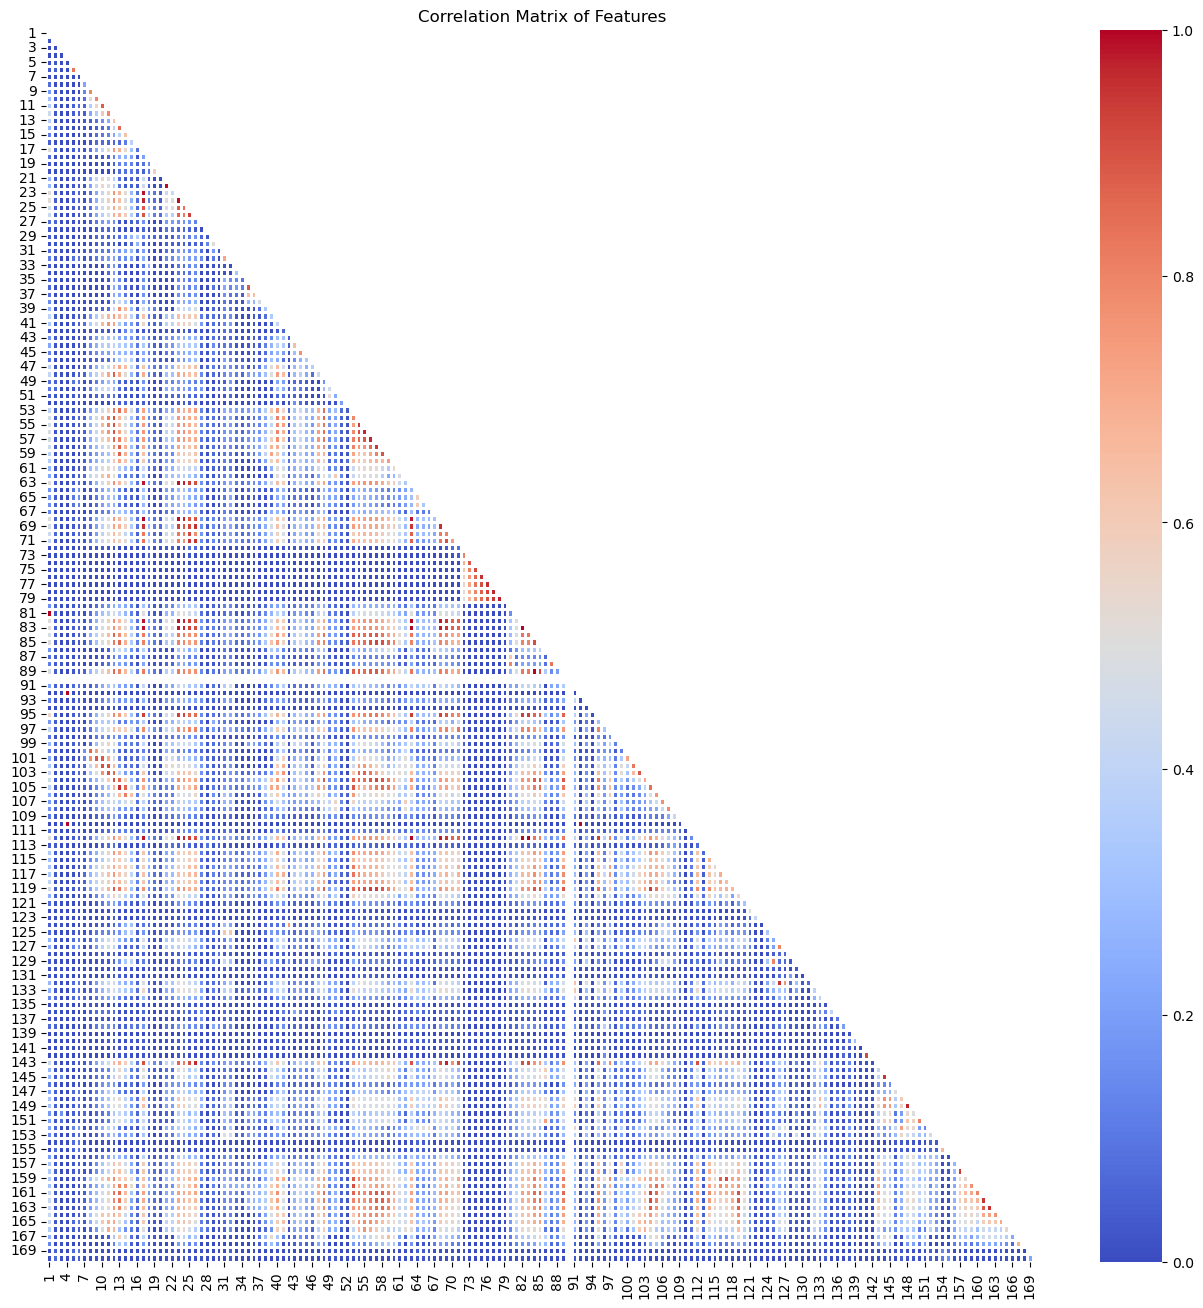

In [5]:
features = df.iloc[:, 1:]
df_corr = features.corr()
mask = np.triu(np.ones_like(df_corr, dtype=bool))
plt.figure(figsize = (16,16))
sns.heatmap(df_corr,mask=mask,linewidths=0.95,cmap="coolwarm", vmin=0,vmax=1)
plt.title("Correlation Matrix of Features")
plt.show()

#### iv. Pick ⌊170⌋ features with highest CV , and make scatter plots and box plots for them, similar to those on p. 129 of ISLR. Can you draw conclusions about significance of those features, just by the scatter plots? This does not mean that you will only use those features in the following questions. We picked them only for visualization.

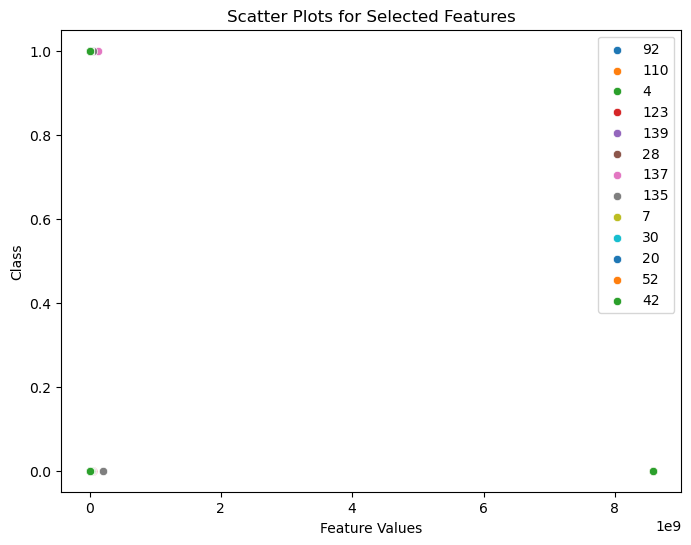

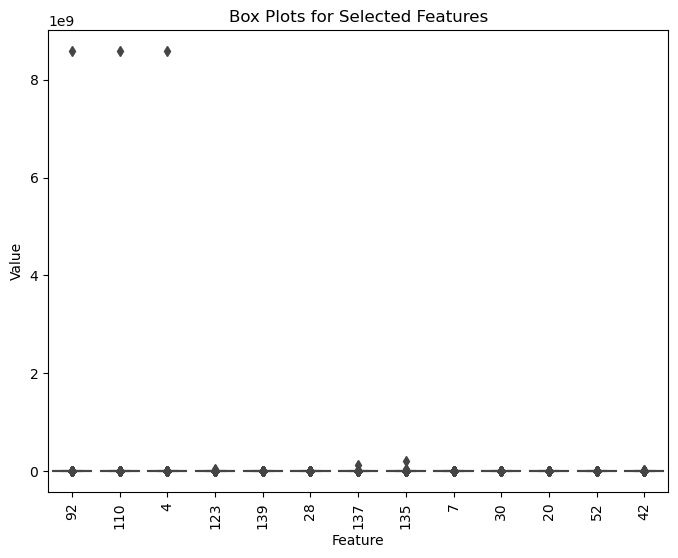

In [6]:
# calculate cv for each feature
cv = (features.std() / features.mean()).sort_values(ascending=False)
n = math.floor(math.sqrt(170))
selected_features = cv[:n].index

class_column = df.columns[0]
plt.figure(figsize=(8, 6))
for feature in selected_features:
    sns.scatterplot(x=df[feature], y=df[class_column], label=feature)
plt.title("Scatter Plots for Selected Features")
plt.xlabel("Feature Values")
plt.ylabel("Class")
plt.legend()
plt.show()

plt.figure(figsize=(8, 6))
sns.boxplot(data=df[selected_features])
plt.title("Box Plots for Selected Features")
plt.xlabel("Feature")
plt.ylabel("Value")
plt.xticks(rotation=90)
plt.show()

#### v. Determine the number of positive and negative data. Is this data set imbalanced?

In [7]:
print("The number of positive data: ", "{:.0f}".format(df[0].sum()))
print("The number of negative data: ", "{:.0f}".format(len(df) - df[0].sum()))
print("The data set is highly imbalanced")

The number of positive data:  1375
The number of negative data:  74625
The data set is highly imbalanced


### (c) Train a random forest to classify the data set. Do NOT compensate for class imbalance in the data set. Calculate the confusion matrix, ROC, AUC, and misclassification for training and test sets and report them (You may use pROC package). Calculate Out of Bag error estimate for your random forset and compare it to the test error.

Confusion Matrix (Train):
 [[59000     0]
 [    1   999]]
Confusion Matrix (Test):
 [[15607    18]
 [  106   269]]
ROC AUC (Train): 0.9995
ROC AUC (Test): 0.8580906666666667
Misclassification Error (Train): 1.666666666666483e-05
Misclassification Error (Test): 0.007750000000000035
Out-of-Bag (OOB) Error: 0.00601666666666667
The oob error is closer to the test error than the train error.


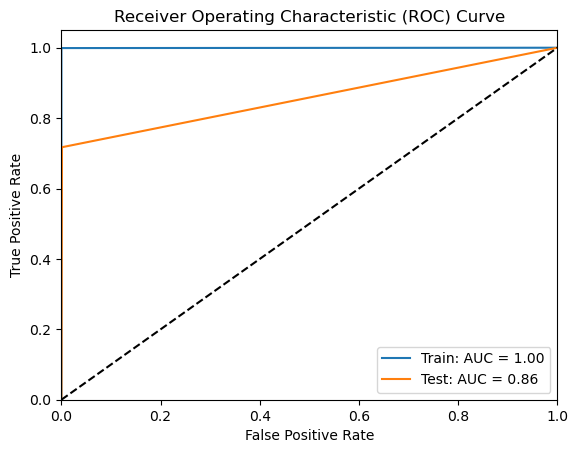

In [8]:
label = df_arr[:,0].astype(int)
features = df_arr[:,1:]
X_train = features[:60000,:]
X_test = features[60000:,:]
y_train = label[:60000]
y_test = label[60000:]

# train the random forest
rf_clf = RandomForestClassifier(oob_score=True, random_state=42, bootstrap=True)
rf_clf.fit(X_train, y_train)
y_train_pred = rf_clf.predict(X_train)
y_test_pred = rf_clf.predict(X_test)

# calculate the confusion matrix, ROC, AUC, misclassification, OOB Error
confusion_train = confusion_matrix(y_train, y_train_pred)
confusion_test = confusion_matrix(y_test, y_test_pred)
fpr_train, tpr_train, _ = roc_curve(y_train, y_train_pred)
fpr_test, tpr_test, _ = roc_curve(y_test, y_test_pred)
roc_auc_train = roc_auc_score(y_train, y_train_pred)
roc_auc_test = roc_auc_score(y_test, y_test_pred)
misclassification_train = 1 - accuracy_score(y_train, y_train_pred)
misclassification_test = 1 - accuracy_score(y_test, y_test_pred)
oob_error = 1 - rf_clf.oob_score_

# print the result
print("Confusion Matrix (Train):\n", confusion_train)
print("Confusion Matrix (Test):\n", confusion_test)
print("ROC AUC (Train):", roc_auc_train)
print("ROC AUC (Test):", roc_auc_test)
print("Misclassification Error (Train):", misclassification_train)
print("Misclassification Error (Test):", misclassification_test)
print("Out-of-Bag (OOB) Error:", oob_error)
print("The oob error is closer to the test error than the train error.")

# plot ROC curves
plt.plot(fpr_train, tpr_train, label='Train: AUC = {:.2f}'.format(roc_auc_train))
plt.plot(fpr_test, tpr_test, label='Test: AUC = {:.2f}'.format(roc_auc_test))
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.show()

### (d) Research how class imbalance is addressed in random forests. Compensate for class imbalance in your random forest and repeat 1c. Compare the results with those of 1c.

Confusion Matrix (Train):
 [[59000     0]
 [    1   999]]
Confusion Matrix (Test):
 [[15615    10]
 [  155   220]]
ROC AUC (Train): 0.9995
ROC AUC (Test): 0.7930133333333333
Misclassification Error (Train): 1.666666666666483e-05
Misclassification Error (Test): 0.010312499999999947
Out-of-Bag (OOB) Error: 0.0074666666666666215
The oob error is closer to the test error than the train error.


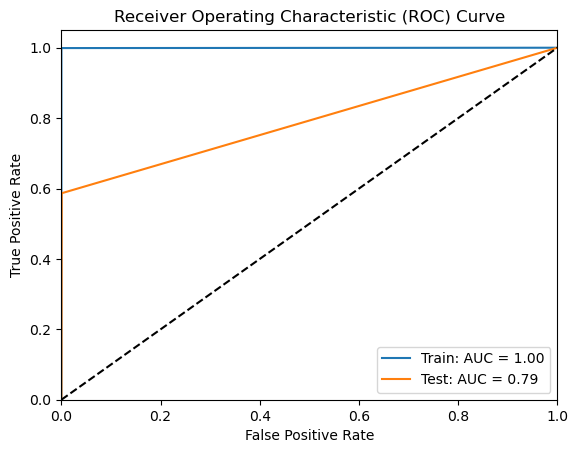

In [9]:
# use class_weight='balanced'
rf_clf_balanced = RandomForestClassifier(class_weight='balanced', oob_score=True, random_state=42, bootstrap=True)

# train the random forest
rf_clf_balanced.fit(X_train, y_train)
y_train_pred = rf_clf_balanced.predict(X_train)
y_test_pred = rf_clf_balanced.predict(X_test)

# calculate the confusion matrix, ROC, AUC, misclassification, OOB Error
confusion_train = confusion_matrix(y_train, y_train_pred)
confusion_test = confusion_matrix(y_test, y_test_pred)
fpr_train, tpr_train, _ = roc_curve(y_train, y_train_pred)
fpr_test, tpr_test, _ = roc_curve(y_test, y_test_pred)
roc_auc_train = roc_auc_score(y_train, y_train_pred)
roc_auc_test = roc_auc_score(y_test, y_test_pred)
misclassification_train = 1 - accuracy_score(y_train, y_train_pred)
misclassification_test = 1 - accuracy_score(y_test, y_test_pred)
oob_error = 1 - rf_clf_balanced.oob_score_

# print the result
print("Confusion Matrix (Train):\n", confusion_train)
print("Confusion Matrix (Test):\n", confusion_test)
print("ROC AUC (Train):", roc_auc_train)
print("ROC AUC (Test):", roc_auc_test)
print("Misclassification Error (Train):", misclassification_train)
print("Misclassification Error (Test):", misclassification_test)
print("Out-of-Bag (OOB) Error:", oob_error)
print("The oob error is closer to the test error than the train error.")

# plot ROC curves
plt.plot(fpr_train, tpr_train, label='Train: AUC = {:.2f}'.format(roc_auc_train))
plt.plot(fpr_test, tpr_test, label='Test: AUC = {:.2f}'.format(roc_auc_test))
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.show()

In (c), the unbalanced Random Forest achieved near-perfect classification on the training set but showed some overfitting on the test set with a slightly lower ROC AUC and minimal misclassification. In (d), the balanced Random Forest maintained strong performance on the training set, addressing class imbalance, but had slightly lower ROC AUC and higher misclassification on the test set. The OOB error estimates were similar, suggesting both models generalize well.

### (e) XGBoost and Model Trees :In the case of a univariate tree, only one input dimension is used at a tree split. In a multivariate tree, or model tree, at a decision node all input dimensions can be used and thus it is more general. In univariate classification trees, majority polling is used at each node to determine the split of that node as the decision rule. In model trees, a (linear) model that relies on all of the variables is used to determine the split of that node (i.e. instead of using Xj > s as the decision rule, one has Pj βjXj > s. as the decision rule). Alternatively, in a regression tree, instead of using average in the region associated with each node, a linear regression model is used to determine the value associated with that node. One of the methods that can be used at each node is Logistic Regression. Because the number of variables is large in this problem, one can use L1-penalized logistic regression at each node. You can use XGBoost to fit the model tree. Determine α (the regularization term) using cross-validation. Train the model for the APS data set without compensation for class imbalance. Use one of 5 fold, 10 fold, and leave-one-out cross validation methods to estimate the error of your trained model and compare it with the test error. Report the Confusion Matrix, ROC, and AUC for training and test sets.

Confusion Matrix (Train):
 [[59000     0]
 [    1   999]]
Confusion Matrix (Test):
 [[15606    19]
 [   85   290]]
ROC AUC (Train): 0.9995
ROC AUC (Test): 0.8860586666666667


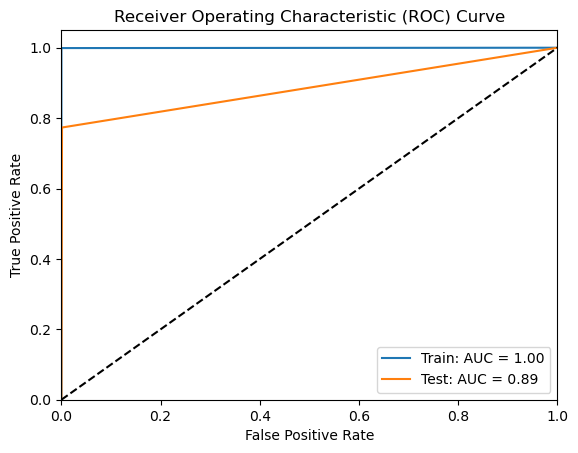

In [10]:
alphas = np.logspace(-2, 0, num=20)
best_score = 0
best_alpha = 0

for alpha in alphas:
    xgb_clf = xgb.XGBClassifier(objective='binary:logistic', reg_alpha=alpha, verbosity=0, use_label_encoder=False)
    scores = cross_val_score(xgb_clf, X_train, y_train, cv=5)
    if best_score < np.mean(scores):
        best_score = np.mean(scores)
        best_alpha = alpha

xgb_clf = xgb.XGBClassifier(objective='binary:logistic', reg_alpha=best_alpha, verbosity=0, use_label_encoder=False)
xgb_clf.fit(X_train, y_train)

y_train_pred = xgb_clf.predict(X_train)
y_test_pred = xgb_clf.predict(X_test)

# calculate the confusion matrix, ROC, AUC, misclassification, OOB Error
confusion_train = confusion_matrix(y_train, y_train_pred)
confusion_test = confusion_matrix(y_test, y_test_pred)
fpr_train, tpr_train, _ = roc_curve(y_train, y_train_pred)
fpr_test, tpr_test, _ = roc_curve(y_test, y_test_pred)
roc_auc_train = roc_auc_score(y_train, y_train_pred)
roc_auc_test = roc_auc_score(y_test, y_test_pred)

# print the result
print("Confusion Matrix (Train):\n", confusion_train)
print("Confusion Matrix (Test):\n", confusion_test)
print("ROC AUC (Train):", roc_auc_train)
print("ROC AUC (Test):", roc_auc_test)

# plot ROC curves
plt.plot(fpr_train, tpr_train, label='Train: AUC = {:.2f}'.format(roc_auc_train))
plt.plot(fpr_test, tpr_test, label='Test: AUC = {:.2f}'.format(roc_auc_test))
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.show()

### (f) Use SMOTE (Synthetic Minority Over-sampling Technique) to pre-process your data to compensate for class imbalance.4 Train XGBoost with L1-penalized logistic regression at each node using the pre-processed data and repeat 1e. Do not forget that there is a right and a wrong way of cross-validation here. Compare the uncompensated case with SMOTE case.

Confusion Matrix (Train):
 [[59000     0]
 [    2   998]]
Confusion Matrix (Test):
 [[15582    43]
 [   66   309]]
ROC AUC (Train): 0.999
ROC AUC (Test): 0.9106239999999999


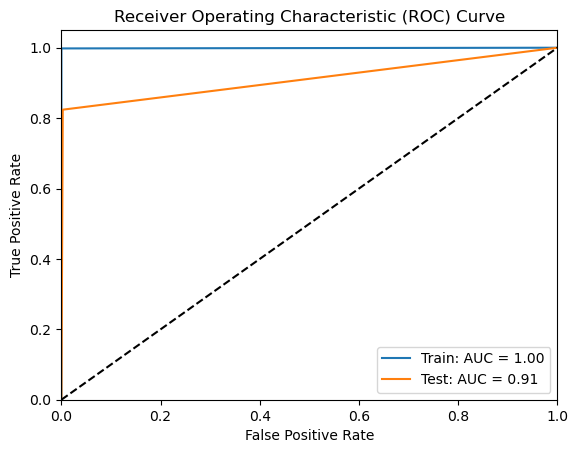

Using SMOTE to deal with imbalanced data can improve the performance and get the better ROC AUC score for test dataset.


In [11]:
alphas = np.logspace(-2, 0, num=8)
best_score = 0
best_alpha = 0

for alpha in alphas:
    test_error=0
    kf = KFold(n_splits=5)
    for train_index, test_index in kf.split(X_train):
        X_train_smote, X_test_smote = X_train[train_index], X_train[test_index]
        y_train_smote, y_test_smote = y_train[train_index], y_train[test_index]

        oversample = SMOTE()
        X_train_smote, y_train_smote = oversample.fit_resample(X_train_smote, y_train_smote)

        xgb_clf_smote = xgb.XGBClassifier(objective='binary:logistic', reg_alpha=alpha, verbosity=0, use_label_encoder=False)
        xgb_clf_smote.fit(X_train_smote,y_train_smote)
        X_test_label = xgb_clf_smote.predict(X_test_smote)
        test_error += zero_one_loss(y_test_smote, X_test_label)

    if best_score < test_error/5:
        best_score = test_error/5
        best_alpha = alpha

oversample = SMOTE()
X_train_smote, y_train_smote = oversample.fit_resample(X_train, y_train)

xgb_clf_smote = xgb.XGBClassifier(objective='binary:logistic', reg_alpha=best_alpha, verbosity=0, use_label_encoder=False)
xgb_clf_smote.fit(X_train_smote, y_train_smote)

y_train_pred = xgb_clf_smote.predict(X_train)
y_test_pred = xgb_clf_smote.predict(X_test)

# calculate the confusion matrix, ROC, AUC, misclassification, OOB Error
confusion_train = confusion_matrix(y_train, y_train_pred)
confusion_test = confusion_matrix(y_test, y_test_pred)
fpr_train, tpr_train, _ = roc_curve(y_train, y_train_pred)
fpr_test, tpr_test, _ = roc_curve(y_test, y_test_pred)
roc_auc_train = roc_auc_score(y_train, y_train_pred)
roc_auc_test = roc_auc_score(y_test, y_test_pred)

# print the result
print("Confusion Matrix (Train):\n", confusion_train)
print("Confusion Matrix (Test):\n", confusion_test)
print("ROC AUC (Train):", roc_auc_train)
print("ROC AUC (Test):", roc_auc_test)

# plot ROC curves
plt.plot(fpr_train, tpr_train, label='Train: AUC = {:.2f}'.format(roc_auc_train))
plt.plot(fpr_test, tpr_test, label='Test: AUC = {:.2f}'.format(roc_auc_test))
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.show()

print("Using SMOTE to deal with imbalanced data can improve the performance and get the better ROC AUC score for test dataset.")